In [1]:
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
#load to traffic volume dataset into dataframe
traffic = 'Metro_Interstate_Traffic_Volume.csv'

df = pd.read_csv(traffic)

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,10/2/2012 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,10/2/2012 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,10/2/2012 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,10/2/2012 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,10/2/2012 13:00,4918


In [4]:
#display the number of rows and columns
df.shape

(48204, 9)

In [5]:
#replace NaNs with the None in the holiday column
df['holiday']  = df['holiday'].fillna('None')

In [6]:
#check the amount of values oer class in the holiday column
df['holiday'].value_counts()

holiday
None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

In [7]:
#check the number of missing values per column
df.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [8]:
df.value_counts()

holiday               temp     rain_1h  snow_1h  clouds_all  weather_main  weather_description      date_time        traffic_volume
None                  288.890  0.0      0.0      1           Clear         sky is clear             9/29/2017 19:00  4498              2
                      295.010  0.0      0.0      40          Clouds        scattered clouds         6/21/2017 11:00  4808              2
                      279.287  0.0      0.0      56          Clouds        broken clouds            10/7/2016 18:00  4642              2
                      289.060  0.0      0.0      90          Clouds        overcast clouds          6/1/2016 10:00   4831              2
                      286.290  0.0      0.0      1           Clear         sky is clear             9/30/2015 19:00  3679              2
                                                                                                                                      ..
                      274.820  0.0      0.0   

In [9]:
#check for the beginning date of the dataset for range
df['date_time'].head(1)

0    10/2/2012 9:00
Name: date_time, dtype: object

In [10]:
#check for the last date of the dataset for range
df['date_time'].tail(1)

48203    9/30/2018 23:00
Name: date_time, dtype: object

In [11]:
#check the number of observations per class for the weather description 
df['weather_description'].value_counts()

weather_description
sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain       

In [12]:
import matplotlib.pyplot as plt 

(15000.0, 50613.15)

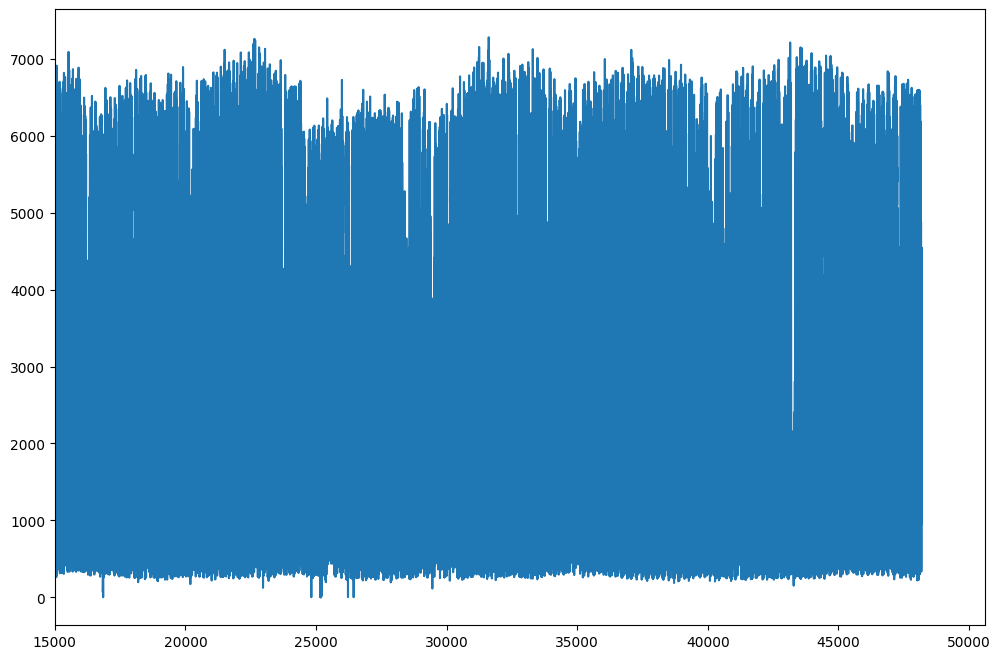

In [13]:
# plot the traffic volume over time
df_traffic = df['traffic_volume']

ax = df_traffic.plot(figsize=(12,8))

ax.set_xlim(15000)

In [14]:
#check the number of unique values per column 
df.nunique()

holiday                   12
temp                    5843
rain_1h                  372
snow_1h                   12
clouds_all                60
weather_main              11
weather_description       38
date_time              40575
traffic_volume          6704
dtype: int64

In [15]:
#remove any duplicate dates sure that each observation has a unique point in time
df = df.drop_duplicates(subset='date_time')

In [16]:
#display rows and columns of dataframe after duplicates were dropped
df.shape

(40575, 9)

In [17]:
#these will be the columns used for our LSTM models
df = df[[ 'traffic_volume', 'date_time' ]]

In [18]:
#check new dataframe after merge
df.head()

,traffic_volume,date_time
0,5545,10/2/2012 9:00
1,4516,10/2/2012 10:00
2,4767,10/2/2012 11:00
3,5026,10/2/2012 12:00
4,4918,10/2/2012 13:00


In [19]:
#sort rows based on date in ascending order
df = df.sort_values('date_time', ascending = True)

In [20]:
# create a new dataframe that excludes the date column 
df_new = df
df_new.shape

(40575, 2)

In [21]:
#check for missing values in new dataframe
df_new.isnull().sum()

traffic_volume    0
date_time         0
dtype: int64

In [22]:
#removing missing values
df_new = df_new.dropna()

In [23]:
df_new.isnull().sum()

traffic_volume    0
date_time         0
dtype: int64

In [24]:
#reset the index 
df_new = df_new.reset_index()

In [25]:
#remove the index column that was created from the index column 
df_new = df_new.drop('index', axis =1 )

In [26]:
df_new = df_new.drop('date_time', axis = 1)

In [27]:
#display the last 5 rows of dataframe
df_new.tail()

,traffic_volume
40570,541
40571,1140
40572,1806
40573,2224
40574,3449


In [28]:
#establish the sequence length that the rnn model will to predict the next data point
seq_length = 95


In [29]:
# split the data into a 90/10 split
length_df = int(len(df_new))

split_percent = 0.1

split_length = round(length_df*split_percent)
df_split_train = length_df - split_length
df_train = df_new[:-split_length]

df_test = df_new[df_split_train-seq_length:]



In [30]:
df_test.head()

,traffic_volume
36422,374
36423,3370
36424,2839
36425,2083
36426,1204


In [31]:
df_test.tail()

,traffic_volume
40570,541
40571,1140
40572,1806
40573,2224
40574,3449


In [32]:
print('df train:', '\n', df_train.shape, '\n', 'df_test:', '\n', df_test.shape)

df train: 
 (36517, 1) 
 df_test: 
 (4153, 1)


In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
#scale the data using the minmax for target datasets
scaler = MinMaxScaler()

scaler.fit(df_train)

MinMaxScaler()

In [35]:
#scale minmax for target data in both testing and training
normalized_train = scaler.transform(df_train)

normalized_test = scaler.transform(df_test)

In [36]:
#check shape of the scaled version of the train target column
normalized_train.shape

(36517, 1)

In [37]:
# fit the training data into a generator designated from time series data
train_tsgenerator = TimeseriesGenerator(data = normalized_train, targets= normalized_train, length= 95, batch_size=10)

In [38]:
#check the length of the generator, which is the number of batches that will be fed to the model for fitting
len(train_tsgenerator)

3643

In [39]:
# a 3 layer LSTM model is created
n_features = 1 # number of input features, which was the one hot encoded columns
model = Sequential()

model.add(LSTM(units= 50, activation='relu', return_sequences= True, input_shape = [seq_length, n_features])) 
model.add(Dropout(0.2)) #dropout layers used for regularization
model.add(LSTM(units = 50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse') #adam optimizer where the loss function is mean square error


In [40]:
#showcase the number of parameters per layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 95, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 95, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 95, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 95, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 

In [41]:
#fit the model using the training generator
model.fit(train_tsgenerator, epochs = 10) # took about a 2 minutes per epoch to train. pretty slow

Epoch 1/10


3643/3643 [==============================] - 110s 30ms/step - loss: 0.0485
Epoch 2/10
3643/3643 [==============================] - 112s 31ms/step - loss: 0.0251
Epoch 3/10
3643/3643 [==============================] - 186s 51ms/step - loss: 0.0195
Epoch 4/10
3643/3643 [==============================] - 162s 44ms/step - loss: 0.0158
Epoch 5/10
3643/3643 [==============================] - 224s 62ms/step - loss: 0.0136
Epoch 6/10
3643/3643 [==============================] - 143s 39ms/step - loss: 0.0119
Epoch 7/10
3643/3643 [==============================] - 111s 30ms/step - loss: 0.0109
Epoch 8/10
3643/3643 [==============================] - 112s 31ms/step - loss: 0.0101
Epoch 9/10
3643/3643 [==============================] - 112s 31ms/step - loss: 0.0098
Epoch 10/10
3643/3643 [==============================] - 113s 31ms/step - loss: 0.0093


<Axes: >

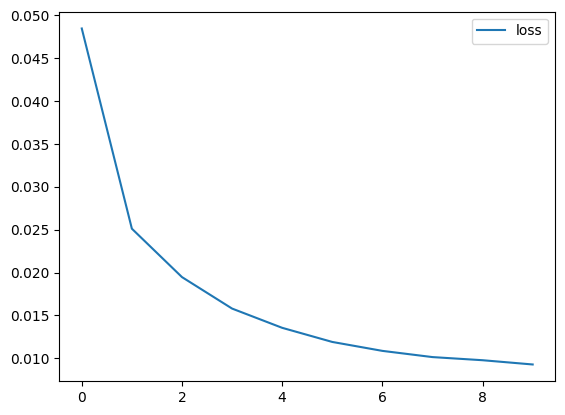

In [42]:
#displays the loss value per epoch
df_model_loss = pd.DataFrame(model.history.history)

df_model_loss.plot()

In [43]:
#create a generator for the testing data for prediction each batch will consist of 1 data ppint
test_tsgenerator = TimeseriesGenerator(normalized_test, normalized_test, length = 95, batch_size = 1)

In [44]:
#predict 3 layer lstm model using testing generator
normalized_prediction = model.predict(test_tsgenerator)

4058/4058 [==============================] - 18s 4ms/step


In [45]:
#remember that these predictions are scaled 0-1
normalized_prediction

array([[0.60489243],
       [0.470011  ],
       [0.04206297],
       ...,
       [0.20883638],
       [0.32126278],
       [0.36498436]], dtype=float32)

In [46]:
#inverse the scale to retrieve the actual predicted values
prediction = scaler.inverse_transform(normalized_prediction)

In [47]:
df_new.head()

,traffic_volume
0,1439
1,1747
2,2291
3,2588
4,2927


In [48]:
df_train.shape

(36517, 1)

In [49]:
df_test.shape

(4153, 1)

In [50]:
df_new.tail()

,traffic_volume
40570,541
40571,1140
40572,1806
40573,2224
40574,3449


In [51]:
#create a dataframe for the predicted values
import numpy as np

pred_index = np.arange(36517, 40575, step = 1)

pred_df = pd.DataFrame(prediction, index = pred_index, columns=['Prediction'])

In [52]:
#retrieve actual values from the original dataframe
y_true = df_new.iloc[36517:40575]

In [53]:
#compute the root mean square error between the actual values and prediction using the 3 layer lstm model
from sklearn.metrics import mean_squared_error

mse_pred1 = np.sqrt(mean_squared_error(y_true, pred_df))

In [54]:
from tensorflow.keras.layers import Conv1D, MaxPool1D

In [55]:
# created a CNN-multi LSTM model 
n_features = 1
model_2 = Sequential()

model_2.add(Conv1D(filters = 32, kernel_size = 4, strides = 2, activation = 'relu', input_shape =  [seq_length, n_features] ))
model_2.add(MaxPool1D(2))
model_2.add(Dropout(0.5))
model_2.add(LSTM(units= 150, activation='relu', return_sequences= True))
model_2.add(Dropout(0.3))
model_2.add(LSTM(units = 100, activation = 'relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(25))
model_2.add(Dropout(0.2))
model_2.add(Dense(1))

model_2.compile(optimizer = 'adam', loss = 'mse')

In [56]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 32)            160       
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 32)            0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 23, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 23, 150)           109800    
                                                                 
 dropout_3 (Dropout)         (None, 23, 150)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               100400    
                                                      

In [57]:
model_2.fit(train_tsgenerator, epochs = 10) #average of 30 seconds of training per epoch. 2nd fastest

Epoch 1/10


3643/3643 [==============================] - 36s 10ms/step - loss: 0.0691
Epoch 2/10
3643/3643 [==============================] - 35s 10ms/step - loss: 0.0440
Epoch 3/10
3643/3643 [==============================] - 35s 10ms/step - loss: 0.0323
Epoch 4/10
3643/3643 [==============================] - 35s 10ms/step - loss: 0.0283
Epoch 5/10
3643/3643 [==============================] - 35s 10ms/step - loss: 0.0260
Epoch 6/10
3643/3643 [==============================] - 36s 10ms/step - loss: 0.0246
Epoch 7/10
3643/3643 [==============================] - 36s 10ms/step - loss: 0.0237
Epoch 8/10
3643/3643 [==============================] - 37s 10ms/step - loss: 0.0231
Epoch 9/10
3643/3643 [==============================] - 35s 10ms/step - loss: 0.0224
Epoch 10/10
3643/3643 [==============================] - 36s 10ms/step - loss: 0.0219


<Axes: >

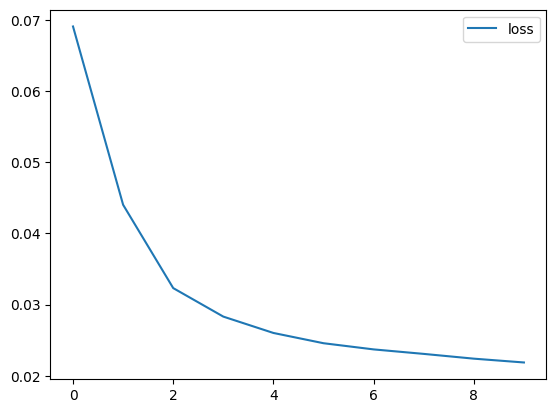

In [58]:
df_model_2_loss = pd.DataFrame(model_2.history.history)

df_model_2_loss.plot()

In [59]:
normalized_prediction2 = model_2.predict(test_tsgenerator)
prediction2 = scaler.inverse_transform(normalized_prediction2)
pred_index2 = np.arange(36517, 40575, step = 1)

pred_df2 = pd.DataFrame(prediction2, index = pred_index2, columns=['Prediction_4'])

#root mean square error for CNN LSTM model
mse_pred2 = np.sqrt(mean_squared_error(y_true, pred_df2))

4058/4058 [==============================] - 6s 1ms/step


In [60]:
print('LSTM-LSTM-LSTM model:', round(mse_pred1,2), '\n', 'CNN-CNN-LSTM-LSTM-LSTM-LSTM:', round(mse_pred2,2))

LSTM-LSTM-LSTM model: 719.27 
 CNN-CNN-LSTM-LSTM-LSTM-LSTM: 973.42


In [61]:
full_scaler = MinMaxScaler()

full_df = df_new[:-seq_length]

eval_df = df_new[-seq_length:]

In [62]:
eval_df.shape

(95, 1)

In [63]:
eval_df.head()

,traffic_volume
40480,4582
40481,4335
40482,2786
40483,4945
40484,5495


In [64]:
normalized_full_df = full_scaler.fit_transform(full_df)

In [65]:
full_tsgenerator = TimeseriesGenerator(normalized_full_df, normalized_full_df, length = 95, batch_size = 10)

In [66]:
model.fit(full_tsgenerator, epochs=10)

Epoch 1/10


4039/4039 [==============================] - 212s 53ms/step - loss: 0.0092
Epoch 2/10
4039/4039 [==============================] - 128s 32ms/step - loss: 0.0089
Epoch 3/10
4039/4039 [==============================] - 128s 32ms/step - loss: 0.0087
Epoch 4/10
4039/4039 [==============================] - 126s 31ms/step - loss: 0.0085
Epoch 5/10
4039/4039 [==============================] - 125s 31ms/step - loss: 0.0082
Epoch 6/10
4039/4039 [==============================] - 125s 31ms/step - loss: 0.0082
Epoch 7/10
4039/4039 [==============================] - 125s 31ms/step - loss: 0.0080
Epoch 8/10
4039/4039 [==============================] - 125s 31ms/step - loss: 0.0079
Epoch 9/10
4039/4039 [==============================] - 125s 31ms/step - loss: 0.0078
Epoch 10/10
4039/4039 [==============================] - 125s 31ms/step - loss: 0.0078


<Axes: >

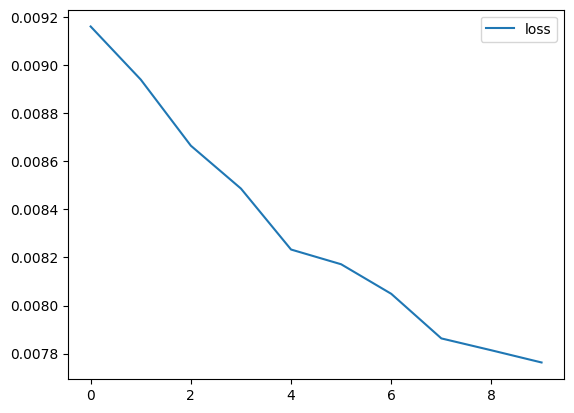

In [67]:
df_model_3_loss = pd.DataFrame(model.history.history)

df_model_3_loss.plot()

In [68]:
full_df

,traffic_volume
0,1439
1,1747
2,2291
3,2588
4,2927
...,...
40475,5842
40476,6612
40477,6292
40478,4944


In [69]:
eval_df

,traffic_volume
40480,4582
40481,4335
40482,2786
40483,4945
40484,5495
...,...
40570,541
40571,1140
40572,1806
40573,2224


In [70]:
#forecasts the next 117 datapoints using the last 60 datapoints in the full normalized dataset
forecast = []

time_period = 95

first_eval_batch = normalized_full_df[-seq_length:]
current_batch = first_eval_batch.reshape(1, seq_length, n_features)

for i in range(time_period):
    forecast_pred = model.predict(current_batch)[0]

    forecast.append(forecast_pred)

    current_batch = np.append(current_batch[:, 1:, :], [[forecast_pred]], axis = 1)

1/1 [==============================] - 0s 15ms/step


In [71]:
#reverts forecasted values back to unscaled form
forecast = full_scaler.inverse_transform(forecast)

forecast

array([[4521.39240265],
       [5066.58912659],
       [5348.58623505],
       [5452.65500546],
       [5731.66673183],
       [6011.21088028],
       [6196.93939686],
       [5455.4846096 ],
       [4275.43944359],
       [3183.4554553 ],
       [ 546.03592873],
       [3214.3504715 ],
       [3197.90092945],
       [2574.1437459 ],
       [1630.37388921],
       [ 225.15985966],
       [ 392.02785611],
       [ 858.88845801],
       [2953.83270979],
       [5763.60901833],
       [6277.0370245 ],
       [5370.68370342],
       [4465.21037579],
       [1390.24708986],
       [4378.98013115],
       [4779.95339394],
       [5073.54576111],
       [5229.27509308],
       [5457.71583557],
       [5739.45302486],
       [5999.25850391],
       [5371.09983444],
       [4188.20727348],
       [3263.79260778],
       [ 525.39828181],
       [3113.81729603],
       [3074.29005623],
       [2712.00699806],
       [1846.72133923],
       [ 307.35517383],
       [ 411.87967062],
       [ 818.335

In [72]:
forecast.shape

(95, 1)

In [73]:
# converts reverted forecasted values into a dataframe
forecast_index = np.arange(40480, 40575, step = 1)

forecast_df = pd.DataFrame(forecast, index = forecast_index, columns = ['Forecast'])

<Axes: >

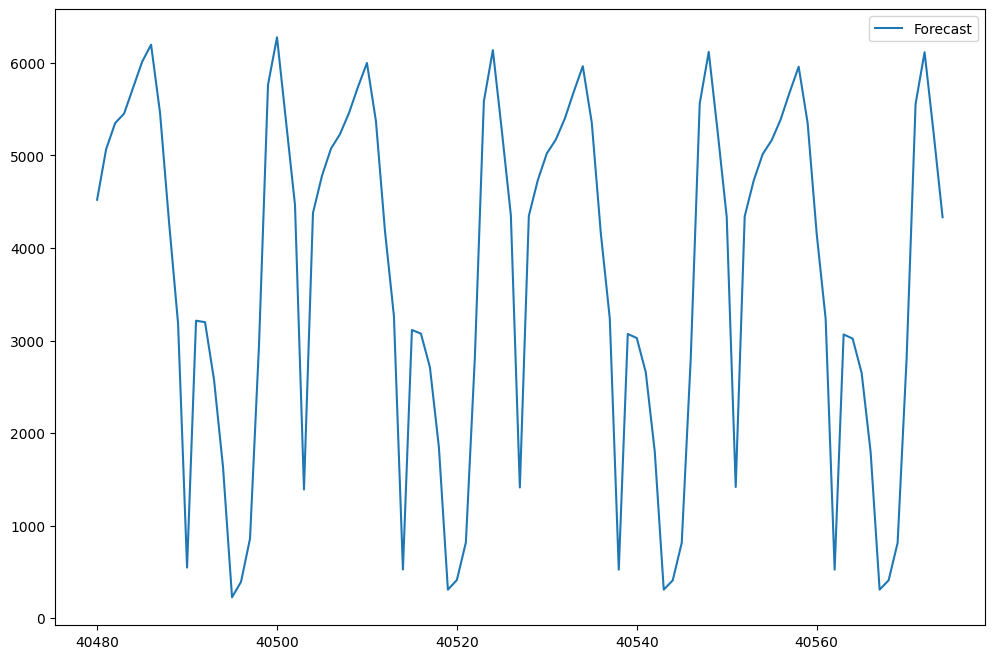

In [74]:
forecast_df.plot(figsize = (12,8))

<Axes: >

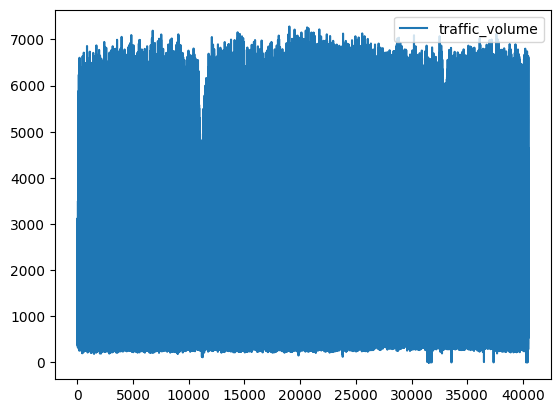

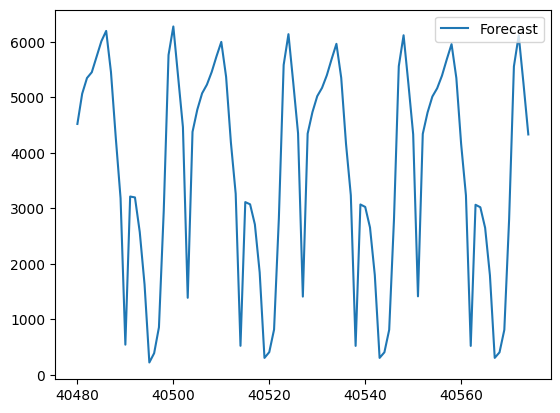

In [75]:
#plots reverted forecasted values with the full dataset in 2 line graphs
full_df.plot()
forecast_df.plot()

<Axes: >

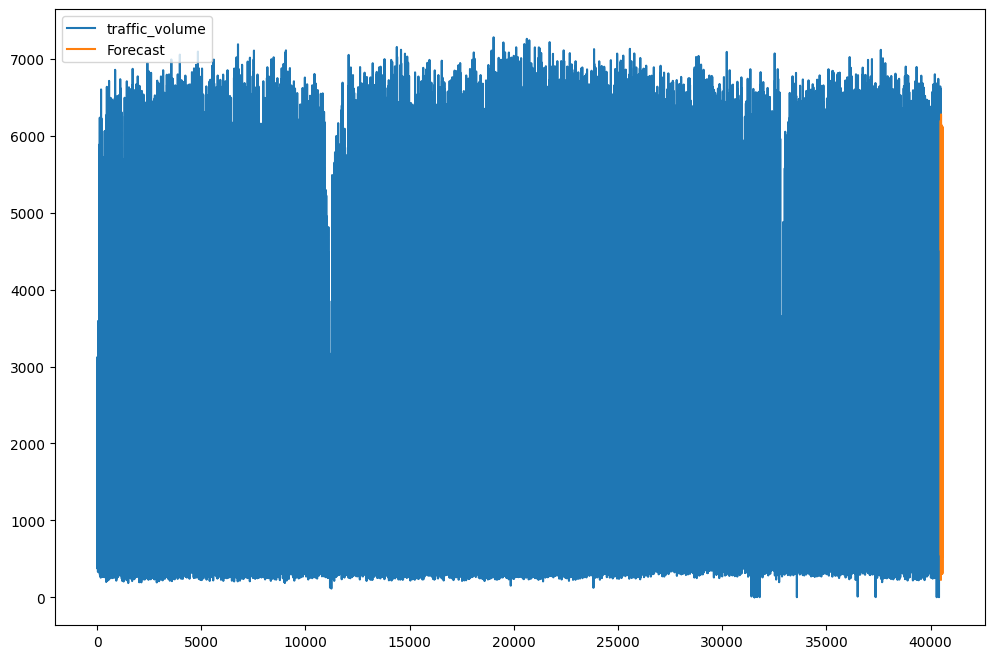

In [76]:
# plot reverted forecasted values with the full dataset values in a single line graph
ax = full_df.plot()

forecast_df.plot(ax = ax, figsize= (12,8))

<Axes: >

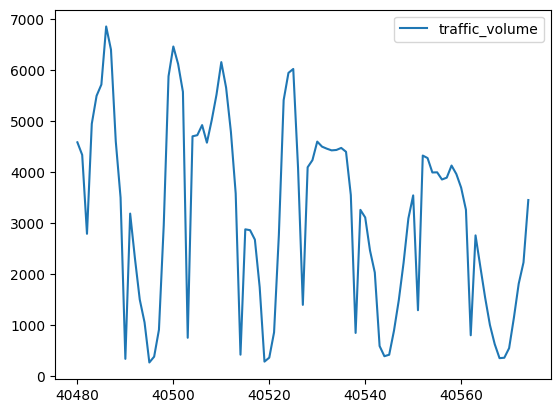

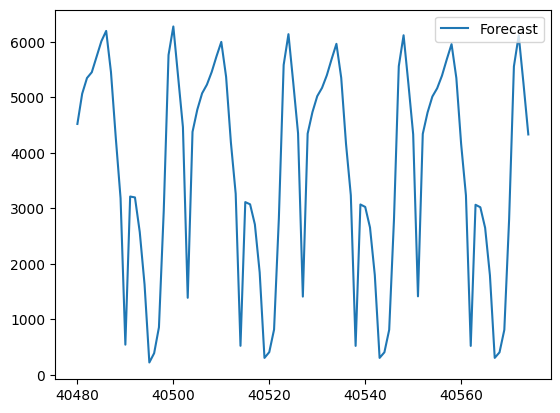

In [77]:
eval_df.plot()
forecast_df.plot()

In [78]:
forecast_rmse = np.sqrt(mean_squared_error(eval_df, forecast_df))

In [79]:
print("forecast_1 rmse:", forecast_rmse)

forecast_1 rmse: 1187.3064651156044


In [80]:
model_2.fit(full_tsgenerator, epochs=10)

Epoch 1/10


4039/4039 [==============================] - 39s 10ms/step - loss: 0.0217
Epoch 2/10
4039/4039 [==============================] - 39s 10ms/step - loss: 0.0213
Epoch 3/10
4039/4039 [==============================] - 40s 10ms/step - loss: 0.0210
Epoch 4/10
4039/4039 [==============================] - 42s 10ms/step - loss: 0.0207
Epoch 5/10
4039/4039 [==============================] - 53s 13ms/step - loss: 0.0204
Epoch 6/10
4039/4039 [==============================] - 49s 12ms/step - loss: 0.0202
Epoch 7/10
4039/4039 [==============================] - 39s 10ms/step - loss: 0.0199
Epoch 8/10
4039/4039 [==============================] - 40s 10ms/step - loss: 0.0197
Epoch 9/10
4039/4039 [==============================] - 39s 10ms/step - loss: 0.0197
Epoch 10/10
4039/4039 [==============================] - 40s 10ms/step - loss: 0.0194


In [81]:
#forecasts the next 117 datapoints using the last 60 datapoints in the full normalized dataset
forecast_2 = []

time_period = 95

first_eval_batch = normalized_full_df[-seq_length:]
current_batch = first_eval_batch.reshape(1, seq_length, n_features)

for i in range(time_period):
    forecast_pred = model_2.predict(current_batch)[0]

    forecast_2.append(forecast_pred)

    current_batch = np.append(current_batch[:, 1:, :], [[forecast_pred]], axis = 1)

1/1 [==============================] - 0s 6ms/step


In [82]:
#reverts forecasted values back to unscaled form
forecast_2 = full_scaler.inverse_transform(forecast_2)

forecast_2

array([[4253.23045731],
       [4369.54927444],
       [4762.9610157 ],
       [5082.46979713],
       [5104.76860523],
       [5146.19468689],
       [5787.24126816],
       [5517.62481689],
       [4304.14944649],
       [3220.16458988],
       [ 683.70283127],
       [2632.45177269],
       [2531.01994514],
       [2274.18335915],
       [1269.2820549 ],
       [ 539.92587566],
       [ 597.02998638],
       [ 777.33816862],
       [2376.34243965],
       [3712.88584709],
       [4489.81938362],
       [4564.89219666],
       [4197.46716499],
       [1103.9044714 ],
       [4152.82702446],
       [4187.42925167],
       [4629.44674492],
       [4517.34911919],
       [4640.75561523],
       [4582.6426363 ],
       [4868.68476391],
       [4675.11614799],
       [3811.34661198],
       [3175.47107697],
       [ 920.48789024],
       [2583.87248993],
       [2375.26154041],
       [2223.98077488],
       [1349.78865385],
       [ 662.50119448],
       [ 527.82423019],
       [ 651.013

In [83]:
# converts reverted forecasted values into a dataframe
forecast_index = np.arange(40480, 40575, step = 1)

forecast_2_df = pd.DataFrame(forecast_2, index = forecast_index, columns = ['Forecast'])

<Axes: >

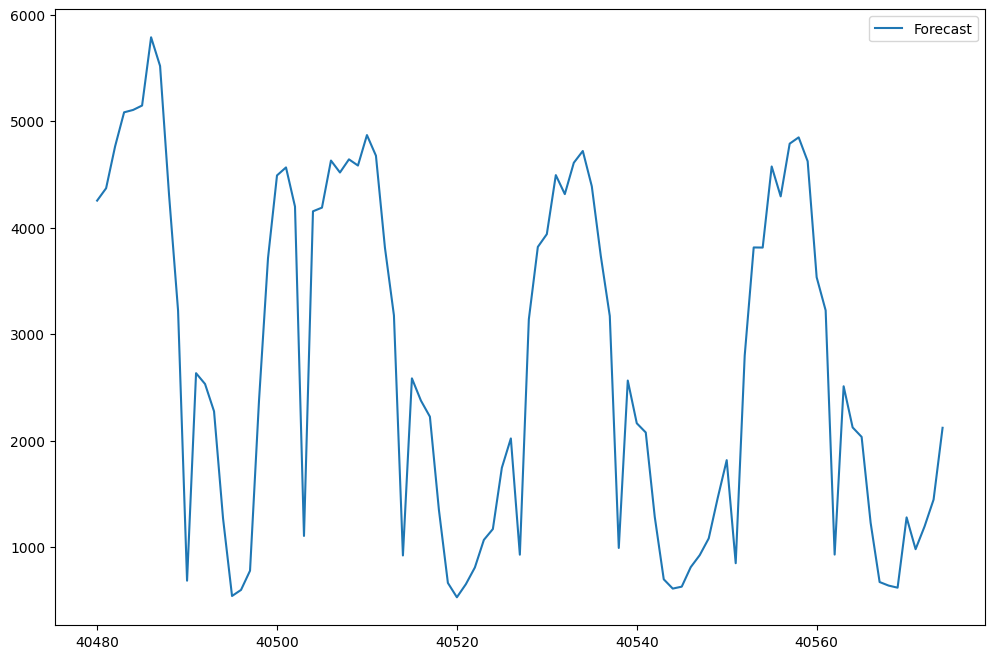

In [84]:
forecast_2_df.plot(figsize = (12,8))

<Axes: >

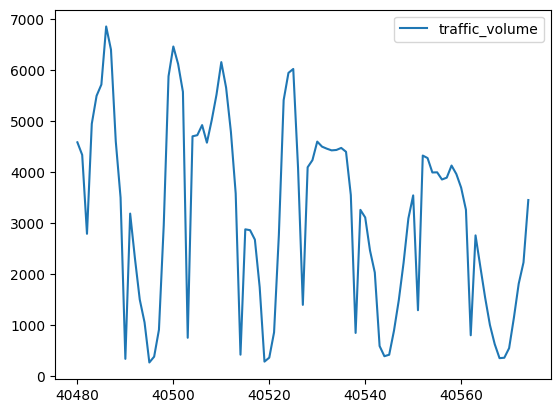

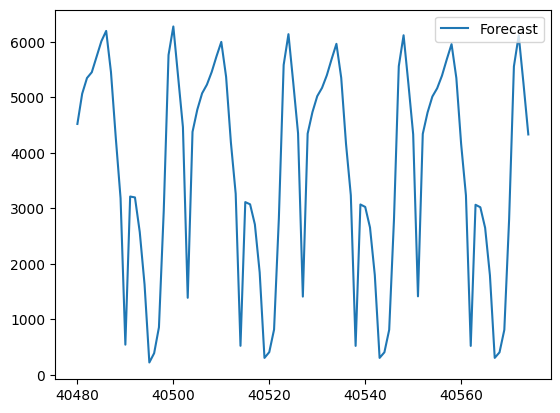

In [85]:
eval_df.plot()
forecast_df.plot()

In [86]:
forecast_2_rmse = np.sqrt(mean_squared_error(eval_df, forecast_2_df))

In [87]:
print("forecast_1 rmse:", forecast_2_rmse)

forecast_1 rmse: 1108.3398596085904
